In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import os
import random

In [2]:
# Dataset and BCI utils
from eeg_dataset_utils import EEGDataset, sampling, flatten
from offline_bci import OfflineBCI, split_by_words

In [4]:
# ML models
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

# Preprocessing tools
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

# Metrics
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, fbeta_score, precision_score, recall_score, confusion_matrix, make_scorer

# Optimization
import optuna

In [5]:
# Sampling
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

In [6]:
# Channel groups
ch_set = {
    1: ['Pz'],
    4: ['Pz', 'POz', 'Cz', 'Fz'],
    8: ['P7', 'P3', 'Pz', 'P4', 'P8', 'POz', 'Cz', 'Fz'],
    16: ['Fz', 'Cz', 'Pz', 'POz', 'P1', 'P2', 'P3','P4', 'P5',
         'P6', 'P7', 'P8', 'PO3', 'PO4', 'O1', 'O2']
}

In [ ]:
# Root directory
rd = "D:\Study\MSUAI\P300BCI_ordered_DataSet"

In [7]:
from copy import deepcopy

# Pipeline for learning and testing
def pipeline(dataset:EEGDataset, models:dict, n_train=3,
             average=1, scoring:list=None, sampling_mode:str=None, 
             discret=500, scaler=None, **kwargs):
    
    # Devide into train and test
    train_set, test_set = split_by_words(dataset, n_train)
    if scaler:
        scaler = RobustScaler().fit(flatten(train_set.x))
    
    # Fix imbalance on train
    data = sampling(train_set, mode=[sampling_mode])
    train_set = EEGDataset(data=data[sampling_mode]['x'], labels=data[sampling_mode]['y'])    
    
    # Averaging
    train_set.average(average)
    test_set_no_average = deepcopy(test_set) # save for BCI tests
    test_set.average(average)
    
    # X, y extraction
    X_train, y_train = train_set.x.copy(), train_set.y.copy()
    X_test, y_test = test_set.x.copy(), test_set.y.copy()
    X_train = scaler.transform(X_train) if scaler else X_train
    X_test = scaler.transform(flatten(X_test)) if scaler else flatten(X_test)

    metrics = []
   
    models_run = deepcopy(models) # To prevent multiple fitting of the models
    
    # For each model of interest
    for name, model in models_run.items():
        
        # Fit and calculate predictions
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        # Calculate classic metrics
        res = get_scores(y_test, y_pred, scoring) # calculate classical metrics
        res.update({'model': name, 'sampling': sampling_mode})
        res.update(confusion_matrix_scores(y_test, y_pred))
        # Calculate BCI metrics
        if scaler:
            pipe = make_pipeline(scaler, model)
        bci = OfflineBCI(test_set_no_average, pipe)
        itr, p = bci.pipeline(average)
        res.update({'itr': itr, 'bci_accuracy': p})
        # Add testing information
        res.update({'channels': len(dataset.picked)})
        res.update({'discretization': discret})
        res.update({'epochs': average})
        
        metrics.append(pd.Series(res))

    return pd.DataFrame(metrics)
            

def get_scores(y_true, y_pred, scoring=None):
    '''Get different scores
    
    Arguments:
    scoring -- str or list of str containing names
               of metrics to be calculated. May be:
               'accuracy', 'balanced_accuracy', 'f1',
               'fbeta', 'precision', 'recall'
    
    Returns:
    scores -- dict with corresponding scores values
    
    '''    
    
    if not scoring:
        fb = fbeta_score(y_true, y_pred, beta=0.5)
    else:
        fb = None
    
    metrics = {
        'accuracy': accuracy_score,
        'balanced_accuracy': balanced_accuracy_score,
        'f1': f1_score,
        'precision': precision_score,
        'recall': recall_score
    }
    
    scoring = scoring if scoring else list(metrics.keys())
    
    scores = dict.fromkeys(scoring)
    
    for k, v in scores.items():
        scores[k] = metrics[k](y_true, y_pred)

    if fb:
        scores.update({'fbeta': fb})
    
    return scores
    
def confusion_matrix_scores(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    # NOTE: метрики развернуты, нужно менять наименования классов (target-1, nontarget-0)
    return {'tn': cm[0, 0], 'fp': cm[0, 1],
            'fn': cm[1, 0], 'tp': cm[1, 1]}
   

In [9]:
from itertools import product
# Downsampling, balance, electrodes, epochs
grid = list(product((32, 60, 120, 250), ('real', 'over'), (1, 4, 8, 16), (1, 2, 4, 6, 8)))

In [156]:
# Define models

rf_params = {
    'n_estimators': 2000,
    'max_depth': 7,
    'min_samples_leaf': 4,
    'min_samples_split': 7,
    'max_features': 'log2',
    'random_state': 42,
    'n_jobs': -1
}

lgb_params = {
    'random_state': 42,
    'n_jobs': -1,
    'n_estimators': 1500,
    'learning_rate': 0.2,
    'max_depth': 9,
    'num_leaves': 35,
    'min_child_weight': 0.001,
    'min_data_in_leaf': 30,
    'verbose': -1
}

xgb_params = {
    'n_estimators': 700,
    'learning_rate': 1,
    'max_depth': 3,
    'min_child_weight': 0.001,
    'random_state': 42,
    'n_jobs':-1,
}

catb_params = {
    'iterations': 1500,
    'learning_rate': 0.2,
    'depth': 9,
    'min_data_in_leaf': 30,
    'random_state': 42,
    'verbose': 0
}

svm = SVC(kernel='rbf', C=10, class_weight='balanced', random_state=42)

lda = LDA()

rf = RandomForestClassifier(**rf_params)
rf_untuned = RandomForestClassifier(random_state=42, n_jobs=-1)

xgb_untuned = XGBClassifier(random_state=42, n_jobs=-1)
xgb = XGBClassifier(**xgb_params) 

lgb_untuned = LGBMClassifier(random_state=42, n_jobs=-1)
lgb = LGBMClassifier(**lgb_params)

catb_untuned = CatBoostClassifier(random_state=42, verbose=0)
# catb = CatBoostClassifier(**catb_params)

In [22]:

models = {
    'LDA': lda,
    'SVM': svm,
    'RF_untuned': rf_untuned,
    'RF': rf,
    'XGB_untuned': xgb_untuned,
    'XGB': xgb,
    'LGB_untuned': lgb_untuned,
    'LGB': lgb,
    'CatBoost_untuned': catb_untuned
}

In [23]:
from tqdm import tqdm

# Create dataset
dataset = EEGDataset(rd, 'ik')
dataset.labels = np.abs(dataset.labels-1) # turn target id to 1

grid_res = []

# Rin tests
for discret, sampl, n_channels, average in tqdm(grid):
    
    dataset.pick_channels(ch_set[n_channels])
    ds = 500//discret
    dataset.downsample(ds)
    
    res = pipeline(dataset, models, average=average, sampling_mode=sampl, discret=discret, scaler=RobustScaler())
    
    grid_res.append(res)

  0%|          | 0/160 [00:00<?, ?it/s]c:\Users\Timot\anaconda3\envs\bci\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Timot\anaconda3\envs\bci\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


  1%|          | 1/160 [00:21<57:01, 21.52s/it]c:\Users\Timot\anaconda3\envs\bci\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


  1%|▏         | 2/160 [00:36<46:41, 17.73s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


  2%|▏         | 3/160 [00:48<38:52, 14.86s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


  2%|▎         | 4/160 [00:56<32:22, 12.45s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


  3%|▎         | 5/160 [01:05<28:18, 10.96s/it]c:\Users\Timot\anaconda3\envs\bci\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


  4%|▍         | 6/160 [01:35<45:11, 17.61s/it]c:\Users\Timot\anaconda3\envs\bci\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


  4%|▍         | 7/160 [01:54<46:12, 18.12s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


  5%|▌         | 8/160 [02:09<43:21, 17.11s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


  6%|▌         | 9/160 [02:23<40:05, 15.93s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


  6%|▋         | 10/160 [02:37<38:23, 15.35s/it]c:\Users\Timot\anaconda3\envs\bci\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Timot\anaconda3\envs\bci\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


  7%|▋         | 11/160 [03:12<53:19, 21.48s/it]c:\Users\Timot\anaconda3\envs\bci\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


  8%|▊         | 12/160 [03:41<58:30, 23.72s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


  8%|▊         | 13/160 [04:01<55:32, 22.67s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


  9%|▉         | 14/160 [04:19<51:57, 21.36s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


  9%|▉         | 15/160 [04:39<49:59, 20.69s/it]c:\Users\Timot\anaconda3\envs\bci\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


 10%|█         | 16/160 [05:36<1:16:09, 31.73s/it]c:\Users\Timot\anaconda3\envs\bci\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


 11%|█         | 17/160 [06:15<1:20:35, 33.81s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


 11%|█▏        | 18/160 [06:47<1:19:06, 33.43s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


 12%|█▏        | 19/160 [07:18<1:16:54, 32.72s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


 12%|█▎        | 20/160 [07:47<1:13:36, 31.55s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


 13%|█▎        | 21/160 [08:10<1:07:01, 28.93s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


 14%|█▍        | 22/160 [08:25<56:58, 24.77s/it]  

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


 14%|█▍        | 23/160 [08:35<46:27, 20.35s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


 15%|█▌        | 24/160 [08:43<38:02, 16.78s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


 16%|█▌        | 25/160 [08:52<32:21, 14.38s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


 16%|█▋        | 26/160 [09:26<45:14, 20.26s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


 17%|█▋        | 27/160 [09:50<47:30, 21.43s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


 18%|█▊        | 28/160 [10:07<44:18, 20.14s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


 18%|█▊        | 29/160 [10:22<40:33, 18.57s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


 19%|█▉        | 30/160 [10:37<37:27, 17.28s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


 19%|█▉        | 31/160 [11:21<54:50, 25.51s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


 20%|██        | 32/160 [11:53<58:35, 27.47s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


 21%|██        | 33/160 [12:18<56:05, 26.50s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


 21%|██▏       | 34/160 [12:39<52:23, 24.95s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


 22%|██▏       | 35/160 [12:59<49:02, 23.54s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


 22%|██▎       | 36/160 [14:09<1:17:04, 37.29s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


 23%|██▎       | 37/160 [14:57<1:23:20, 40.65s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


 24%|██▍       | 38/160 [15:35<1:20:55, 39.80s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


 24%|██▍       | 39/160 [16:08<1:15:56, 37.66s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


 25%|██▌       | 40/160 [16:39<1:11:52, 35.94s/it]c:\Users\Timot\anaconda3\envs\bci\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


 26%|██▌       | 41/160 [17:03<1:04:00, 32.27s/it]c:\Users\Timot\anaconda3\envs\bci\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


 26%|██▋       | 42/160 [17:19<53:37, 27.27s/it]  

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


 27%|██▋       | 43/160 [17:30<44:00, 22.57s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


 28%|██▊       | 44/160 [17:40<36:05, 18.66s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


 28%|██▊       | 45/160 [17:49<30:24, 15.86s/it]c:\Users\Timot\anaconda3\envs\bci\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


 29%|██▉       | 46/160 [18:23<40:21, 21.24s/it]c:\Users\Timot\anaconda3\envs\bci\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


 29%|██▉       | 47/160 [18:48<42:14, 22.43s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


 30%|███       | 48/160 [19:08<40:14, 21.56s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


 31%|███       | 49/160 [19:25<37:38, 20.35s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


 31%|███▏      | 50/160 [19:43<35:34, 19.40s/it]c:\Users\Timot\anaconda3\envs\bci\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


 32%|███▏      | 51/160 [20:32<51:49, 28.52s/it]c:\Users\Timot\anaconda3\envs\bci\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


 32%|███▎      | 52/160 [21:09<55:43, 30.95s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


 33%|███▎      | 53/160 [21:39<54:54, 30.79s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


 34%|███▍      | 54/160 [22:08<53:02, 30.02s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


 34%|███▍      | 55/160 [22:35<50:59, 29.13s/it]c:\Users\Timot\anaconda3\envs\bci\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


 35%|███▌      | 56/160 [23:54<1:16:26, 44.10s/it]c:\Users\Timot\anaconda3\envs\bci\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


 36%|███▌      | 57/160 [24:55<1:24:27, 49.20s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


 36%|███▋      | 58/160 [25:47<1:25:01, 50.01s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


 37%|███▋      | 59/160 [26:35<1:23:34, 49.64s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


 38%|███▊      | 60/160 [27:22<1:21:13, 48.74s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


 38%|███▊      | 61/160 [27:52<1:10:54, 42.97s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


 39%|███▉      | 62/160 [28:11<58:46, 35.98s/it]  

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


 39%|███▉      | 63/160 [28:24<47:08, 29.16s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


 40%|████      | 64/160 [28:36<38:05, 23.81s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


 41%|████      | 65/160 [28:47<31:35, 19.95s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


 41%|████▏     | 66/160 [29:29<41:41, 26.61s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


 42%|████▏     | 67/160 [29:59<43:04, 27.79s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


 42%|████▎     | 68/160 [30:22<40:18, 26.29s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


 43%|████▎     | 69/160 [30:42<37:05, 24.45s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


 44%|████▍     | 70/160 [31:02<34:18, 22.87s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


 44%|████▍     | 71/160 [31:59<49:14, 33.20s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


 45%|████▌     | 72/160 [32:41<52:27, 35.77s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


 46%|████▌     | 73/160 [33:13<50:20, 34.72s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


 46%|████▋     | 74/160 [33:44<48:00, 33.49s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


 47%|████▋     | 75/160 [34:12<45:25, 32.07s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


 48%|████▊     | 76/160 [35:45<1:10:10, 50.12s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


 48%|████▊     | 77/160 [36:56<1:18:21, 56.64s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


 49%|████▉     | 78/160 [37:54<1:17:58, 57.05s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


 49%|████▉     | 79/160 [38:46<1:14:48, 55.41s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


 50%|█████     | 80/160 [39:36<1:11:31, 53.64s/it]c:\Users\Timot\anaconda3\envs\bci\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


 51%|█████     | 81/160 [40:03<1:00:20, 45.84s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


 51%|█████▏    | 82/160 [40:21<48:51, 37.58s/it]  

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


 52%|█████▏    | 83/160 [40:35<39:03, 30.43s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


 52%|█████▎    | 84/160 [40:47<31:33, 24.92s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


 53%|█████▎    | 85/160 [40:59<26:14, 21.00s/it]c:\Users\Timot\anaconda3\envs\bci\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


 54%|█████▍    | 86/160 [41:48<36:13, 29.38s/it]c:\Users\Timot\anaconda3\envs\bci\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


 54%|█████▍    | 87/160 [42:26<38:48, 31.90s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


 55%|█████▌    | 88/160 [42:57<38:01, 31.68s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


 56%|█████▌    | 89/160 [43:26<36:28, 30.82s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


 56%|█████▋    | 90/160 [43:53<34:38, 29.69s/it]c:\Users\Timot\anaconda3\envs\bci\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


 57%|█████▋    | 91/160 [45:15<52:16, 45.45s/it]c:\Users\Timot\anaconda3\envs\bci\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


 57%|█████▊    | 92/160 [46:15<56:29, 49.84s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


 58%|█████▊    | 93/160 [47:05<55:46, 49.94s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


 59%|█████▉    | 94/160 [47:53<54:07, 49.21s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


 59%|█████▉    | 95/160 [48:39<52:25, 48.39s/it]c:\Users\Timot\anaconda3\envs\bci\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


 60%|██████    | 96/160 [50:55<1:19:39, 74.68s/it]c:\Users\Timot\anaconda3\envs\bci\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


 61%|██████    | 97/160 [52:44<1:29:01, 84.78s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


 61%|██████▏   | 98/160 [54:20<1:31:09, 88.22s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


 62%|██████▏   | 99/160 [55:51<1:30:36, 89.13s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


 62%|██████▎   | 100/160 [57:20<1:29:01, 89.02s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


 63%|██████▎   | 101/160 [57:55<1:11:43, 72.94s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


 64%|██████▍   | 102/160 [58:19<56:06, 58.05s/it]  

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


 64%|██████▍   | 103/160 [58:35<43:23, 45.67s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


 65%|██████▌   | 104/160 [58:50<33:57, 36.38s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


 66%|██████▌   | 105/160 [59:04<27:14, 29.72s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


 66%|██████▋   | 106/160 [1:00:06<35:21, 39.29s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


 67%|██████▋   | 107/160 [1:00:52<36:22, 41.18s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


 68%|██████▊   | 108/160 [1:01:28<34:21, 39.64s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


 68%|██████▊   | 109/160 [1:01:59<31:28, 37.02s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


 69%|██████▉   | 110/160 [1:02:28<29:00, 34.81s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


 69%|██████▉   | 111/160 [1:04:01<42:44, 52.33s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


 70%|███████   | 112/160 [1:05:13<46:33, 58.19s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


 71%|███████   | 113/160 [1:06:11<45:34, 58.17s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


 71%|███████▏  | 114/160 [1:07:07<44:04, 57.48s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


 72%|███████▏  | 115/160 [1:07:59<41:44, 55.66s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


 72%|███████▎  | 116/160 [1:10:42<1:04:34, 88.06s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


 73%|███████▎  | 117/160 [1:12:57<1:13:06, 102.02s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


 74%|███████▍  | 118/160 [1:14:46<1:12:56, 104.19s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


 74%|███████▍  | 119/160 [1:16:26<1:10:21, 102.97s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


 75%|███████▌  | 120/160 [1:18:01<1:07:04, 100.61s/it]c:\Users\Timot\anaconda3\envs\bci\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


 76%|███████▌  | 121/160 [1:18:39<53:09, 81.77s/it]   

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


 76%|███████▋  | 122/160 [1:19:06<41:20, 65.28s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


 77%|███████▋  | 123/160 [1:19:27<32:05, 52.03s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


 78%|███████▊  | 124/160 [1:19:46<25:12, 42.00s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


 78%|███████▊  | 125/160 [1:20:04<20:22, 34.91s/it]c:\Users\Timot\anaconda3\envs\bci\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


 79%|███████▉  | 126/160 [1:21:27<27:53, 49.23s/it]c:\Users\Timot\anaconda3\envs\bci\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


 79%|███████▉  | 127/160 [1:22:31<29:30, 53.65s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


 80%|████████  | 128/160 [1:23:23<28:27, 53.36s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


 81%|████████  | 129/160 [1:24:13<26:55, 52.13s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


 81%|████████▏ | 130/160 [1:25:01<25:27, 50.93s/it]c:\Users\Timot\anaconda3\envs\bci\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


 82%|████████▏ | 131/160 [1:27:25<38:07, 78.88s/it]c:\Users\Timot\anaconda3\envs\bci\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


 82%|████████▎ | 132/160 [1:29:21<42:00, 90.03s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


 83%|████████▎ | 133/160 [1:31:00<41:44, 92.76s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


 84%|████████▍ | 134/160 [1:32:28<39:30, 91.19s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


 84%|████████▍ | 135/160 [1:33:51<37:00, 88.82s/it]c:\Users\Timot\anaconda3\envs\bci\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


 85%|████████▌ | 136/160 [1:38:04<55:18, 138.25s/it]c:\Users\Timot\anaconda3\envs\bci\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


 86%|████████▌ | 137/160 [1:41:32<1:00:55, 158.94s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


 86%|████████▋ | 138/160 [1:44:33<1:00:42, 165.58s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


 87%|████████▋ | 139/160 [1:47:23<58:29, 167.10s/it]  

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


 88%|████████▊ | 140/160 [1:50:08<55:27, 166.38s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


 88%|████████▊ | 141/160 [1:50:50<40:49, 128.90s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


 89%|████████▉ | 142/160 [1:51:20<29:50, 99.48s/it] 

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


 89%|████████▉ | 143/160 [1:51:44<21:44, 76.71s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


 90%|█████████ | 144/160 [1:52:05<15:58, 59.88s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


 91%|█████████ | 145/160 [1:52:25<11:58, 47.92s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


 91%|█████████▏| 146/160 [1:54:01<14:33, 62.42s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


 92%|█████████▏| 147/160 [1:55:13<14:07, 65.21s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


 92%|█████████▎| 148/160 [1:56:13<12:46, 63.90s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


 93%|█████████▎| 149/160 [1:57:11<11:21, 61.97s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


 94%|█████████▍| 150/160 [1:58:03<09:49, 58.96s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


 94%|█████████▍| 151/160 [2:00:48<13:36, 90.77s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


 95%|█████████▌| 152/160 [2:03:00<13:45, 103.18s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


 96%|█████████▌| 153/160 [2:04:48<12:13, 104.76s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


 96%|█████████▋| 154/160 [2:06:33<10:29, 104.86s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


 97%|█████████▋| 155/160 [2:08:13<08:36, 103.22s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


 98%|█████████▊| 156/160 [2:13:29<11:08, 167.17s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


 98%|█████████▊| 157/160 [2:17:30<09:27, 189.22s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


 99%|█████████▉| 158/160 [2:20:49<06:24, 192.23s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


 99%|█████████▉| 159/160 [2:23:54<03:09, 189.92s/it]

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


100%|██████████| 160/160 [2:26:51<00:00, 55.07s/it] 


In [8]:
# Optuna configuration

def objective(trial):
    
    ds_params = {
        'discret': trial.suggest_categorical('discret', [32, 60, 120, 250]),
        'sampling': trial.suggest_categorical('sampling', ['real', 'over']),
        'channels': trial.suggest_categorical('channels', [1, 4, 8, 16]),
        'epochs': 8 # trial.suggest_int('epochs', 1, 9, 2)
    }
    
    dataset = EEGDataset(rd, 'ik')
    dataset.labels = np.abs(dataset.labels-1)
    dataset.pick_channels(ch_set[ds_params['channels']])
    dataset.downsample(500//ds_params['discret'])
    
    train_set, test_set = split_by_words(dataset, 3)
    scaler = RobustScaler().fit(flatten(train_set.x))
    
    data = sampling(train_set, mode=[ds_params['sampling']])
    train_set = EEGDataset(data=data[ds_params['sampling']]['x'], labels=data[ds_params['sampling']]['y'])
    
    train_set.average(ds_params['epochs'])
    test_set.average(ds_params['epochs'])
    
    X_train, y_train = train_set.x.copy(), train_set.y.copy()
    X_test, y_test = test_set.x.copy(), test_set.y.copy()
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(flatten(X_test))
    
    # rf_params = {
    #     "n_estimators": trial.suggest_int(name="n_estimators", low=100, high=2500, step=200),
    #     "max_depth": trial.suggest_int("max_depth", 3, 10),
    #     'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
    #     'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
    #     "max_features": trial.suggest_categorical(
    #         "max_features", choices=["sqrt", "log2"]
    #     ),
    #     "n_jobs": -1,
    #     "random_state": 42,
    #     'class_weight': 'balanced'
    # }
    
    # model = RandomForestClassifier(**rf_params)
    
    # svm_params = {
    #     'kernel': trial.suggest_categorical('kernel', ['rbf']),
    #     'C': trial.suggest_categorical('C', [1, 10, 100, 1000]),
    #     "random_state": 42,
    #     'class_weight': 'balanced'
    # }
    
    # model = SVC(class_weight='balanced', random_state=42, **svm_params)
    
    lgb_params = {
        "n_estimators": trial.suggest_int(name="n_estimators", low=500, high=2500, step=100),
        'learning_rate': trial.suggest_float('leaning_rate', 0.1, 1, step=0.1),
        'max_depth': trial.suggest_int('max_depth', 3, 30),
        'num_leaves': trial.suggest_int('num_leaves', 2, 40, 2),
        'min_child_weight': trial.suggest_float('min_child_weight', 1e-4, 1e2, log=True),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 40, 1),
        "n_jobs": -1,
        "random_state": 42
    }
    
    # model = LGBMClassifier(**lgb_params)
    
    # xgb_params = {
    #     'n_estimators': trial.suggest_int(name="n_estimators", low=500, high=1000, step=100),
    #     'learning_rate': trial.suggest_float('leaning_rate', 0.1, 1, step=0.1),
    #     'max_depth': trial.suggest_int('max_depth', 3, 30),
    #     'min_child_weight': trial.suggest_float('min_child_weight', 1e-4, 1e2, log=True),
    #     'random_state': 42,
    #     'n_jobs':-1,
    # }
    
    # model = XGBClassifier(**xgb_params)
    
    # catb_params = {
    #     'iterations': trial.suggest_int(name="n_estimators", low=500, high=2500, step=100),
    #     'learning_rate': trial.suggest_float('learning_rate', 0.1, 1, step=0.1),
    #     'depth': trial.suggest_int('depth', 3, 16),
    #     'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 30, 1),
    #     'l2_leaf_reg': trial.suggest_int('l2_leaf_reg', 2, 30, 1),
    #     'random_state': 42,
    #     'verbose': 0
    # }
    
    # model = CatBoostClassifier(**catb_params)
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    return fbeta_score(y_test, y_pred, beta=0.5)
# f1_score(y_test, y_pred)
# get_scores(y_test, y_pred)
# balanced_accuracy_score(y_test, y_pred)
# fbeta_score(y_test, y_pred, beta=0.5) 

In [9]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10, n_jobs=-1, show_progress_bar=True)

[I 2023-11-15 19:07:26,626] A new study created in memory with name: no-name-7c93ba62-f33b-4927-963c-c3b41e0f49c8


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2023-11-15 19:07:54,533] Trial 5 finished with value: 0.7954545454545454 and parameters: {'discret': 250, 'sampling': 'real', 'channels': 1, 'n_estimators': 700, 'learning_rate': 0.5, 'depth': 3, 'min_data_in_leaf': 18, 'l2_leaf_reg': 6}. Best is trial 5 with value: 0.7954545454545454.


In [153]:
best_res = objective(study.best_trial)
best_res

{'accuracy': 0.9553571428571429,
 'balanced_accuracy': 0.7916666666666667,
 'f1': 0.7368421052631579,
 'precision': 1.0,
 'recall': 0.5833333333333334,
 'fbeta': 0.875}

In [101]:
print(study.best_value)
print(study.best_params)


0.875
{'discret': 32, 'n_estimators': 500, 'leaning_rate': 1.0, 'max_depth': 3, 'min_child_weight': 0.001349542799239913}


In [25]:
params_collection = []
params_collection.append((study.best_value, study.best_params))

In [102]:
optuna.visualization.plot_slice(study)

In [103]:
df = study.trials_dataframe()
df = df.drop(columns=['datetime_start', 'datetime_complete', 'duration', 'state'])
df.head()

,number,value,params_discret,params_leaning_rate,params_max_depth,params_min_child_weight,params_n_estimators
0,0,0.750000,60,0.1,19,0.007037,700
1,1,0.833333,120,0.6,6,0.089371,700
2,2,0.750000,60,0.4,7,0.113847,500
3,3,0.000000,32,0.6,18,31.775200,900
4,4,0.833333,250,0.1,20,0.000949,600


In [104]:
df = df[df.value>=0.85]
df = df.sort_values('value', ascending=False)
df
# df.query(''' params_channels==8 ''')

,number,value,params_discret,params_leaning_rate,params_max_depth,params_min_child_weight,params_n_estimators
15,15,0.875,32,1.0,3,0.001350,500
23,23,0.875,32,1.0,3,0.000792,700
24,24,0.875,32,1.0,3,0.001203,700
25,25,0.875,32,1.0,3,0.000325,700
26,26,0.875,32,1.0,3,0.000370,700
27,27,0.875,32,1.0,3,0.000823,700
32,32,0.875,32,1.0,3,0.000106,800
51,51,0.875,250,0.7,6,0.007467,700
90,90,0.875,120,0.3,4,0.000202,700


In [105]:
df.median()

number                      26.000000
value                        0.875000
params_discret              32.000000
params_leaning_rate          1.000000
params_max_depth             3.000000
params_min_child_weight      0.000792
params_n_estimators        700.000000
dtype: float64

# Transfer learning

Is not finally implemented yet

In [116]:

subjects = ['ak', 'as', 'az', 'dad', 'dkv', 'ds', 'dsi', 'dzg', 'tp', 'ik']


In [139]:
result = []
for train_subject in tqdm(subjects):
    
    for test_subject in subjects:
        
        train_set = EEGDataset(rd, train_subject)
        train_set.labels = np.abs(train_set.labels-1)
        train_set.pick_channels(ch_set[8])
        train_set.downsample(15)
        
        if train_subject==test_subject:
            train_set, test_set = split_by_words(train_set, 3)
        else:
            test_set = EEGDataset(rd, test_subject)
            test_set.labels = np.abs(test_set.labels-1)
            test_set.pick_channels(ch_set[8])
            test_set.downsample(15)
            
            train_set, _ = split_by_words(train_set, 3)
            _, test_set = split_by_words(test_set, 3)

        scaler = RobustScaler().fit(flatten(train_set.x))

        # Fix imbalance on train
        sampling_mode = 'real'
        data = sampling(train_set, mode=[sampling_mode])
        train_set = EEGDataset(data=data[sampling_mode]['x'], labels=data[sampling_mode]['y'])    

        # Averaging
        average=8
        train_set.average(average)
        test_set_no_average = deepcopy(test_set) # save for BCI tests
        test_set.average(average)

        # X, y extraction
        X_train, y_train = train_set.x.copy(), train_set.y.copy()
        X_test, y_test = test_set.x.copy(), test_set.y.copy()
        X_train = scaler.transform(X_train) if scaler else X_train
        X_test = scaler.transform(flatten(X_test)) if scaler else flatten(X_test)

        model = SVC()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        res = get_scores(y_pred, y_test)
        res.update({'train_subject': train_subject,
                    'test_subject': test_subject})
        result.append(res)


  0%|          | 0/10 [00:00<?, ?it/s]c:\Users\Timot\anaconda3\envs\bci\lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\Timot\anaconda3\envs\bci\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Timot\anaconda3\envs\bci\lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\Timot\anaconda3\envs\bci\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modi

KeyboardInterrupt: 

In [133]:
df = res.pivot(index='train_subject', columns='test_subject', values='fbeta')

<AxesSubplot: xlabel='test_subject', ylabel='train_subject'>

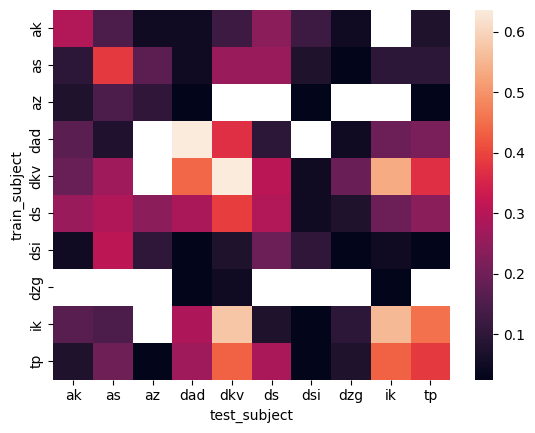

In [134]:
sns.heatmap(df)

In [158]:
# subjects = ['ak', 'as', 'az', 'dad', 'dkv', 'ds', 'dsi', 'dzg', 'eab', 'en', 'fks', 'hra',
#  'ieh', 'ik', 'irk', 'kka', 'kms', 'lv', 'mam', 'mb', 'mbm', 'mbu', 'mma', 'mp',
#  'nb', 'nva', 'rae', 'rkv', 'sav', 'sdk', 'ski', 'smv', 'ss', 'tg', 'tp']
subjects = ['ak', 'as', 'az', 'dad', 'dkv', 'ds', 'dsi', 'dzg', 'tp', 'ss']

In [170]:
def create_dataset(s):
    dataset = EEGDataset(rd, s)
    dataset.labels = np.abs(dataset.labels-1)
    dataset.pick_channels(ch_set[8])
    dataset.downsample(15)
    dataset.average(8)
    return dataset

In [171]:
datasets = [create_dataset(s) for s in subjects]

In [183]:
test_set = create_dataset('mbu')

In [184]:
X_test, y_test = flatten(test_set.x), test_set.y

In [186]:
X = np.vstack([d.x for d in datasets])
y = np.hstack([d.y for d in datasets])

In [185]:
model = SVC(kernel='rbf', C=10, class_weight='balanced', random_state=42)

In [187]:
model.fit(flatten(X), y)
pred = model.predict(X_test)
get_scores(y_test, pred)


{'accuracy': 0.9443207126948775,
 'balanced_accuracy': 0.7587468671679198,
 'f1': 0.6753246753246753,
 'precision': 0.9629629629629629,
 'recall': 0.52,
 'fbeta': 0.8227848101265824}

In [188]:
confusion_matrix_scores(y_test,pred)

{'tn': 398, 'fp': 1, 'fn': 24, 'tp': 26}

In [189]:
tsna = EEGDataset(rd, 'mbu')
tsna.pick_channels(ch_set[8])
tsna.downsample(15)
bci = OfflineBCI(tsna, model)
bci.pipeline(8, summary=True)

Total trials: 20
Correct trials: 7
ITR: 3.19
Classification accuracy: 0.35


(3.18972345831778, 0.35)